Generated curves: 12
Saved: /content/project3_output/pumpdown_points.csv
Saved: /content/project3_output/curve_metadata.csv

Saved fit results: /content/project3_output/curve_fit_results.csv


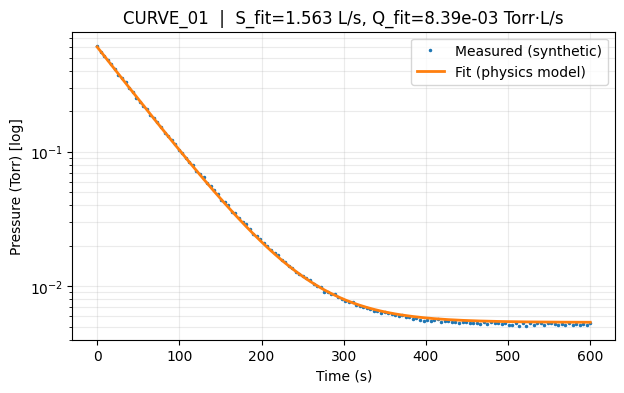

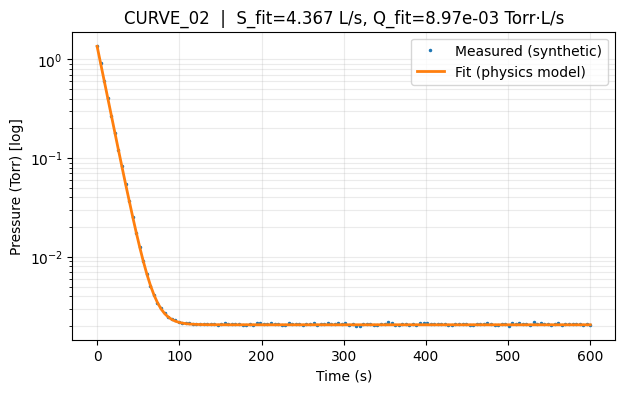

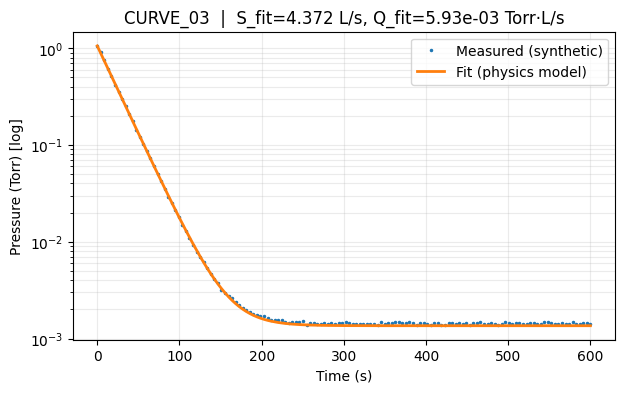


ML performance (predicting fitted parameters from meta/features):
S_fit:   R2=0.595 | MAE=0.964 L/s
log10Q:  R2=-2.010 | MAE=0.721 decades
Saved ML models:
 - /content/project3_output/ml_model_predict_S.pkl
 - /content/project3_output/ml_model_predict_logQ.pkl
Saved ML predictions: /content/project3_output/ml_predictions.csv


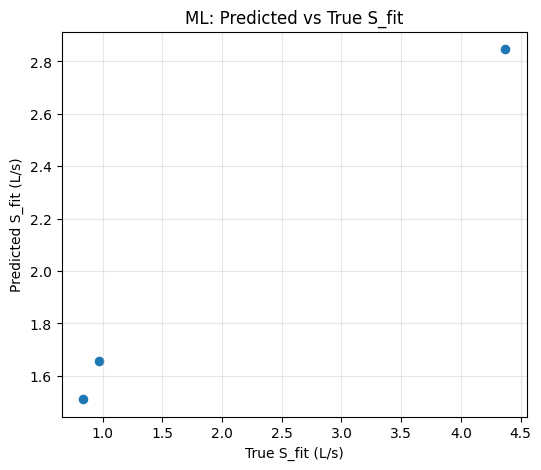

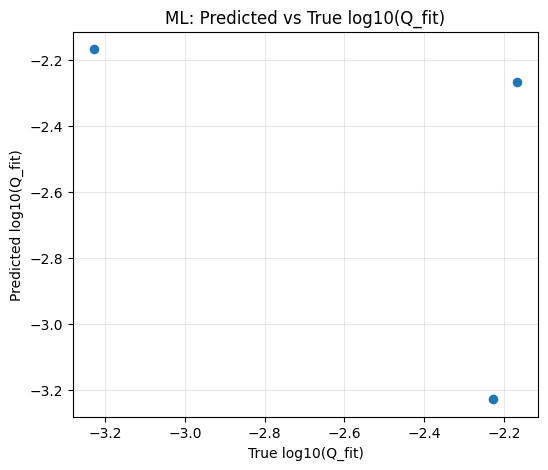


Estimated time-to-target (0.001 Torr) added to curve_fit_results.csv
Outputs saved in: /content/project3_output
 - pumpdown_points.csv
 - curve_metadata.csv
 - curve_fit_results.csv
 - ml_predictions.csv
 - ml_model_predict_S.pkl
 - ml_model_predict_logQ.pkl


In [1]:
# ============================================================
# Project 4 — Vacuum Pumpdown Estimator + Outgassing/Leak Modeling (Physics + Fit + ML)
# Colab-ready (CPU).
#
# What it does:
# 1) Generates 10–15 synthetic pumpdown curves using a physics model:
#       dP/dt = -(S/V)*P + Q/V
#    => P(t) = (P0 - Q/S)*exp(-(S/V)*t) + (Q/S)
#
# 2) Fits S (effective pumping speed) and Q (effective outgassing/leak rate) per curve.
# 3) Uses ML to predict fitted (S, Q) from meta/features (V, valve_open, pump_type, etc).
# 4) Exports:
#    - pumpdown_points.csv     (time series points for all curves)
#    - curve_fit_results.csv   (fitted S, Q per curve)
#    - ml_predictions.csv      (predicted vs true fitted parameters)
#    - saved ML models (.pkl)
# ============================================================

!pip -q install numpy pandas scipy scikit-learn matplotlib joblib

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import joblib

# ----------------------------
# 1) Settings
# ----------------------------
OUT_DIR = "/content/project3_output"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 7
rng = np.random.default_rng(SEED)

N_CURVES = 12               # set between 10 and 15
N_POINTS_PER_CURVE = 140    # time points per curve
T_MAX_S = 600               # max time in seconds

# Pressure units: Torr (synthetic). You can treat as mTorr, Pa, etc—just be consistent.
# We'll start near 1 Torr and decay toward Q/S (the asymptote).
P0_RANGE = (0.6, 1.4)       # initial pressure range [Torr]
V_RANGE_L = (30, 120)       # chamber volume [Liters]
S_RANGE_LPS = (1.0, 7.0)    # effective pumping speed [L/s]
Q_RANGE_TORR_LPS = (1e-4, 8e-3)  # outgassing/leak [Torr*L/s]

# Noise level (relative)
NOISE_REL = 0.015  # 1.5% multiplicative + small additive

# Meta features per curve
PUMP_TYPES = ["dry_pump", "turbo", "cryo"]  # categorical
VALVE_OPEN_RANGE = (0.55, 1.0)             # 0..1 (affects effective S)
LINE_CONDUCTANCE_RANGE = (0.4, 1.0)        # 0..1 (affects effective S)

# ----------------------------
# 2) Physics model & synthetic data generator
# ----------------------------
def pumpdown_pressure_model(t, S, Q, V, P0):
    """Closed-form solution for dP/dt = -(S/V)*P + Q/V."""
    Peq = Q / S
    return (P0 - Peq) * np.exp(-(S / V) * t) + Peq

def generate_curve(curve_id: str):
    # Meta (what you might know from tool configuration)
    V = float(rng.uniform(*V_RANGE_L))
    pump_type = rng.choice(PUMP_TYPES)
    valve_open = float(rng.uniform(*VALVE_OPEN_RANGE))
    line_cond = float(rng.uniform(*LINE_CONDUCTANCE_RANGE))

    # True underlying parameters (what we want to fit)
    # Make S depend on pump_type and valve/conductance for realism
    base_S = float(rng.uniform(*S_RANGE_LPS))
    pump_factor = {"dry_pump": 0.85, "turbo": 1.0, "cryo": 1.15}[pump_type]
    S_true = base_S * pump_factor * valve_open * line_cond

    Q_true = float(rng.uniform(*Q_RANGE_TORR_LPS)) * (1.0 + 0.15*(pump_type == "cryo"))
    P0 = float(rng.uniform(*P0_RANGE))

    # time axis
    t = np.linspace(0, T_MAX_S, N_POINTS_PER_CURVE)

    # ideal pressure
    P_ideal = pumpdown_pressure_model(t, S=S_true, Q=Q_true, V=V, P0=P0)

    # add measurement noise (mild)
    mult_noise = rng.normal(0, NOISE_REL, size=t.shape)
    add_noise = rng.normal(0, 2e-5, size=t.shape)
    P_meas = np.clip(P_ideal * (1 + mult_noise) + add_noise, 1e-8, None)

    meta = {
        "curve_id": curve_id,
        "V_L": V,
        "pump_type": pump_type,
        "valve_open": valve_open,
        "line_conductance": line_cond,
        "P0_Torr": P0,
        "S_true_Lps": S_true,
        "Q_true_TorrLps": Q_true,
    }

    points = pd.DataFrame({
        "curve_id": curve_id,
        "t_s": t,
        "P_Torr_meas": P_meas,
        "P_Torr_ideal": P_ideal,
    })

    return meta, points

# Generate curves
metas = []
all_points = []
for i in range(N_CURVES):
    cid = f"CURVE_{i+1:02d}"
    meta, pts = generate_curve(cid)
    metas.append(meta)
    all_points.append(pts)

meta_df = pd.DataFrame(metas)
points_df = pd.concat(all_points, ignore_index=True)

points_csv = os.path.join(OUT_DIR, "pumpdown_points.csv")
meta_csv = os.path.join(OUT_DIR, "curve_metadata.csv")
points_df.to_csv(points_csv, index=False)
meta_df.to_csv(meta_csv, index=False)

print("Generated curves:", N_CURVES)
print("Saved:", points_csv)
print("Saved:", meta_csv)
meta_df.head()


# ----------------------------
# 3) Fit S and Q for each curve (physics-based fitting)
# ----------------------------
def fit_S_Q_for_curve(t, P, V, P0):
    """
    Fit S, Q for a given curve using curve_fit on the closed-form model:
      P(t) = (P0 - Q/S)*exp(-(S/V)*t) + (Q/S)

    We pass V and P0 as fixed values and fit (S, Q).
    """
    def model_wrapped(t, S, Q):
        return pumpdown_pressure_model(t, S=S, Q=Q, V=V, P0=P0)

    # initial guesses
    # S guess ~ 3 L/s, Q guess ~ 1e-3 Torr*L/s
    p0 = [3.0, 1e-3]

    # bounds: keep physically positive
    bounds = ([1e-4, 1e-8], [50.0, 0.2])

    popt, pcov = curve_fit(
        model_wrapped, t, P, p0=p0, bounds=bounds, maxfev=20000
    )
    S_hat, Q_hat = popt
    return float(S_hat), float(Q_hat), pcov

fit_rows = []
for _, row in meta_df.iterrows():
    cid = row["curve_id"]
    V = float(row["V_L"])
    P0 = float(row["P0_Torr"])

    sub = points_df[points_df["curve_id"] == cid].sort_values("t_s")
    t = sub["t_s"].to_numpy()
    P = sub["P_Torr_meas"].to_numpy()

    S_hat, Q_hat, _ = fit_S_Q_for_curve(t, P, V=V, P0=P0)

    # quick fit quality: compute predicted pressures and MAE in Torr
    P_fit = pumpdown_pressure_model(t, S=S_hat, Q=Q_hat, V=V, P0=P0)
    mae_torr = float(np.mean(np.abs(P_fit - P)))
    r2_fit = float(1 - np.sum((P - P_fit)**2) / np.sum((P - P.mean())**2))

    fit_rows.append({
        "curve_id": cid,
        "V_L": V,
        "pump_type": row["pump_type"],
        "valve_open": float(row["valve_open"]),
        "line_conductance": float(row["line_conductance"]),
        "P0_Torr": P0,
        "S_true_Lps": float(row["S_true_Lps"]),
        "Q_true_TorrLps": float(row["Q_true_TorrLps"]),
        "S_fit_Lps": S_hat,
        "Q_fit_TorrLps": Q_hat,
        "fit_mae_Torr": mae_torr,
        "fit_r2": r2_fit,
        "Peq_fit_Torr": Q_hat / S_hat,
    })

fit_df = pd.DataFrame(fit_rows).sort_values("curve_id")
fit_csv = os.path.join(OUT_DIR, "curve_fit_results.csv")
fit_df.to_csv(fit_csv, index=False)

print("\nSaved fit results:", fit_csv)
fit_df[["curve_id","S_true_Lps","S_fit_Lps","Q_true_TorrLps","Q_fit_TorrLps","fit_r2"]].head()


# ----------------------------
# 4) Plot a few fitted curves (measured vs fit)
# ----------------------------
def plot_curve_fit(curve_id):
    row = fit_df[fit_df["curve_id"] == curve_id].iloc[0]
    V = float(row["V_L"])
    P0 = float(row["P0_Torr"])
    S_hat = float(row["S_fit_Lps"])
    Q_hat = float(row["Q_fit_TorrLps"])

    sub = points_df[points_df["curve_id"] == curve_id].sort_values("t_s")
    t = sub["t_s"].to_numpy()
    P = sub["P_Torr_meas"].to_numpy()

    P_fit = pumpdown_pressure_model(t, S=S_hat, Q=Q_hat, V=V, P0=P0)

    plt.figure(figsize=(7, 4))
    plt.plot(t, P, marker=".", linestyle="None", markersize=3, label="Measured (synthetic)")
    plt.plot(t, P_fit, linewidth=2, label="Fit (physics model)")
    plt.yscale("log")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (Torr) [log]")
    plt.title(f"{curve_id}  |  S_fit={S_hat:.3f} L/s, Q_fit={Q_hat:.2e} Torr·L/s")
    plt.grid(True, which="both", alpha=0.25)
    plt.legend()
    plt.show()

# Show 3 examples
for cid in fit_df["curve_id"].iloc[:3]:
    plot_curve_fit(cid)


# ----------------------------
# 5) ML: Predict fitted pumpdown parameters (S_fit, Q_fit) from meta/features
# ----------------------------
# Goal: given tool configuration signals, predict expected (S, Q) for health monitoring / forecasting.

ml_df = fit_df.copy()

# Features
X = ml_df[["V_L", "valve_open", "line_conductance", "pump_type"]]
X = pd.get_dummies(X, columns=["pump_type"], drop_first=False)

# Targets (fitted parameters)
# Predict S directly, and log(Q) because Q spans orders of magnitude.
y_S = ml_df["S_fit_Lps"].astype(float)
y_logQ = np.log10(ml_df["Q_fit_TorrLps"].astype(float))

X_train, X_test, yS_train, yS_test = train_test_split(X, y_S, test_size=0.25, random_state=SEED)
_, _, yQ_train, yQ_test = train_test_split(X, y_logQ, test_size=0.25, random_state=SEED)

# Train ML models
mS = RandomForestRegressor(n_estimators=500, random_state=SEED, n_jobs=-1, min_samples_leaf=1)
mQ = RandomForestRegressor(n_estimators=500, random_state=SEED, n_jobs=-1, min_samples_leaf=1)

mS.fit(X_train, yS_train)
mQ.fit(X_train, yQ_train)

predS = mS.predict(X_test)
predlogQ = mQ.predict(X_test)

print("\nML performance (predicting fitted parameters from meta/features):")
print(f"S_fit:   R2={r2_score(yS_test, predS):.3f} | MAE={mean_absolute_error(yS_test, predS):.3f} L/s")
print(f"log10Q:  R2={r2_score(yQ_test, predlogQ):.3f} | MAE={mean_absolute_error(yQ_test, predlogQ):.3f} decades")

# Save ML models
mS_path = os.path.join(OUT_DIR, "ml_model_predict_S.pkl")
mQ_path = os.path.join(OUT_DIR, "ml_model_predict_logQ.pkl")
joblib.dump(mS, mS_path)
joblib.dump(mQ, mQ_path)
print("Saved ML models:")
print(" -", mS_path)
print(" -", mQ_path)

# Create a prediction table
pred_df = X_test.copy()
pred_df["S_fit_true"] = yS_test.values
pred_df["S_fit_pred"] = predS
pred_df["Q_fit_true"] = (10 ** yQ_test.values)
pred_df["Q_fit_pred"] = (10 ** predlogQ)

pred_csv = os.path.join(OUT_DIR, "ml_predictions.csv")
pred_df.to_csv(pred_csv, index=False)
print("Saved ML predictions:", pred_csv)

# Plot predicted vs true for S
plt.figure(figsize=(6, 5))
plt.scatter(pred_df["S_fit_true"], pred_df["S_fit_pred"], s=35)
plt.xlabel("True S_fit (L/s)")
plt.ylabel("Predicted S_fit (L/s)")
plt.title("ML: Predicted vs True S_fit")
plt.grid(True, alpha=0.3)
plt.show()

# Plot predicted vs true for Q (log scale)
plt.figure(figsize=(6, 5))
plt.scatter(np.log10(pred_df["Q_fit_true"]), np.log10(pred_df["Q_fit_pred"]), s=35)
plt.xlabel("True log10(Q_fit)")
plt.ylabel("Predicted log10(Q_fit)")
plt.title("ML: Predicted vs True log10(Q_fit)")
plt.grid(True, alpha=0.3)
plt.show()


# ----------------------------
# 6) Convenience: Pumpdown time-to-target estimator using fitted parameters
# ----------------------------
def time_to_target(P_target, S, Q, V, P0):
    """
    Solve for t when P(t) reaches P_target:
    P(t) = (P0 - Q/S)*exp(-(S/V)t) + Q/S
    """
    Peq = Q / S
    # If target is below asymptote, you can't reach it in this simple model
    if P_target <= Peq:
        return np.inf
    num = (P_target - Peq)
    den = (P0 - Peq)
    if den <= 0 or num <= 0:
        return np.inf
    t = -(V / S) * np.log(num / den)
    return float(t)

P_TARGET = 1e-3  # Torr
tt = []
for _, row in fit_df.iterrows():
    t_est = time_to_target(P_TARGET, row["S_fit_Lps"], row["Q_fit_TorrLps"], row["V_L"], row["P0_Torr"])
    tt.append(t_est)

fit_df["t_to_1e-3Torr_s_est"] = tt
fit_df.to_csv(fit_csv, index=False)  # overwrite with new column

print(f"\nEstimated time-to-target ({P_TARGET} Torr) added to curve_fit_results.csv")
print("Outputs saved in:", OUT_DIR)
print(" - pumpdown_points.csv")
print(" - curve_metadata.csv")
print(" - curve_fit_results.csv")
print(" - ml_predictions.csv")
print(" - ml_model_predict_S.pkl")
print(" - ml_model_predict_logQ.pkl")
